In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoConfig

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 0 HF_HOME: /local1/mohsenfayyaz/.hfcache/


# Download Dataset + DecompX Tensors

In [2]:
DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
# DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--contriever-msmarco_7170.pkl'

In [3]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(3)

{'model': 'facebook/contriever-msmarco', 'query_model': 'facebook/contriever-msmarco', 'context_model': 'facebook/contriever-msmarco', 'pooling': 'avg', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.46109, 'NDCG@3': 0.49878, 'NDCG@5': 0.50989, 'NDCG@10': 0.5215, 'NDCG@100': 0.54809, 'NDCG@1000': 0.56627}, 'map': {'MAP@1': 0.46109, 'MAP@3': 0.48954, 'MAP@5': 0.49568, 'MAP@10': 0.50046, 'MAP@100': 0.50531, 'MAP@1000': 0.50593}, 'recall': {'Recall@1': 0.46109, 'Recall@3': 0.52552, 'Recall@5': 0.55258, 'Recall@10': 0.58856, 'Recall@100': 0.72008, 'Recall@1000': 0.86709}, 'precision': {'P@1': 0.46109, 'P@3': 0.17517, 'P@5': 0.11052, 'P@10': 0.05886, 'P@100': 0.0072, 'P@1000': 0.00087}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 1.4679288864135742, 'min'...",{'Loud Tour': 1.4679288864135742},"{'Loud Tour': 1.4679288864135742, 'Poetry Bus ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,1.467929,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,1.467929,142,142,"[[CLS], when, was, loud, tour, published, ?, [...","[None, 0, 1, 2, 3, 4, 4, None]","[-0.0074200705, 0.07639864, -0.083429314, 0.00...","[-1.010608, 0.23060957, -0.025443379, 2.001933...","[[0.05046981, -0.012882221, 0.036922462, 0.014...","[[CLS], loud, tour, the, loud, tour, was, the,...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[-0.0074472474, -0.040222168, -0.008159401, 0....","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[[CLS], loud, tour, the, loud, tour, was, the,...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[-0.0074472474, -0.040222168, -0.008159401, 0....","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014..."
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 1.610438585281372, 'min':...",{'Loud Tour': 1.610438585281372},"{'Loud Tour': 1.610438585281372, 'For Unlawful...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud, Loud Tour}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [18, 19], 'sent_id...",P175,performer,Who performed Loud Tour?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall a

# Plot DecompRAG

In [4]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib

def print_importance(importance, tokenized_text, discrete=False, prefix=""):
    """
    importance: (sent_len)
    """
    assert len(importance) == len(tokenized_text)
    importance = importance / np.abs(importance).max() / 1.0  # Normalize
    if discrete:
        importance = np.argsort(np.argsort(importance)) / len(importance) / 1.6

    html = "<pre style='line-height: 28px; display: flex; flex-flow: row wrap;'>"+prefix
    for i in range(len(tokenized_text)):
        # if importance[i] > 0:
        #     rgba = plt.get_cmap('Reds')(importance[i] * .7)   # Wistia
        # else:
        #     rgba = plt.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
        rgba = plt.get_cmap('coolwarm')((importance[i] + 1) / 2)
        text_color = "color: rgba(255, 255, 255, 1.0); " if np.abs(importance[i]) > 1 else "color: rgba(10, 10, 10, 1.0); "
        color = f"background-color: rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]}); " + text_color
        html += (f"<div style='"
                 f"{color}"
                 f"border-radius: 5px; padding: 2px; margin: 1px;"
                 f"font-weight: {int(800)};"
                 "width: fit-content; display: flex;"
                 "'>")
        html += tokenized_text[i].replace('<', "[").replace(">", "]")
        html += "</div> "
        if tokenized_text[i] in ["hypothesis,", "hold.", '"contradiction"']:
            html += '<br>'
    return html

def html_wrapper(htmls, desc="text", legend="?"):
    html = ""
    head = """
    <head>
    <style>
        @media print {
            -webkit-print-color-adjust: exact;
        }
        fieldset {
            max-width: 1000px; padding: 8px; border-radius: 20px; border: 3px solid rgb(15, 200, 200); background: white; color: black;
        }
        legend {
            margin-left: 10px; padding: 7px; padding-left: 20px; padding-right: 20px; border: 2px solid rgb(15, 200, 200);
            border-radius: 20px; background: white;
            /*font-family: Arial !important;*/
            font-weight: 600;
        }
        table tr td {
            white-space: nowrap; padding: 5px;
        }
    </style>
    </head>
    """
    html += head
    html += f"""
        <fieldset>
            <legend>{legend}</legend>
            <table style='width: 1000px; font-weight: 600; color: black;'>
            """
    for i in range(len(htmls)):
        html += """
        <tr>
        """
        html += f"<td style='text-align: center; width: 100px;'>{desc}:</td><td>"
        html += htmls[i]
        html += "</td></tr>"
    html += "</table></fieldset>"
    return html

Query:,[CLS] which administrative territorial entity is west saint joseph street located in ? [SEP]


Gold Doc:


Pred Doc:


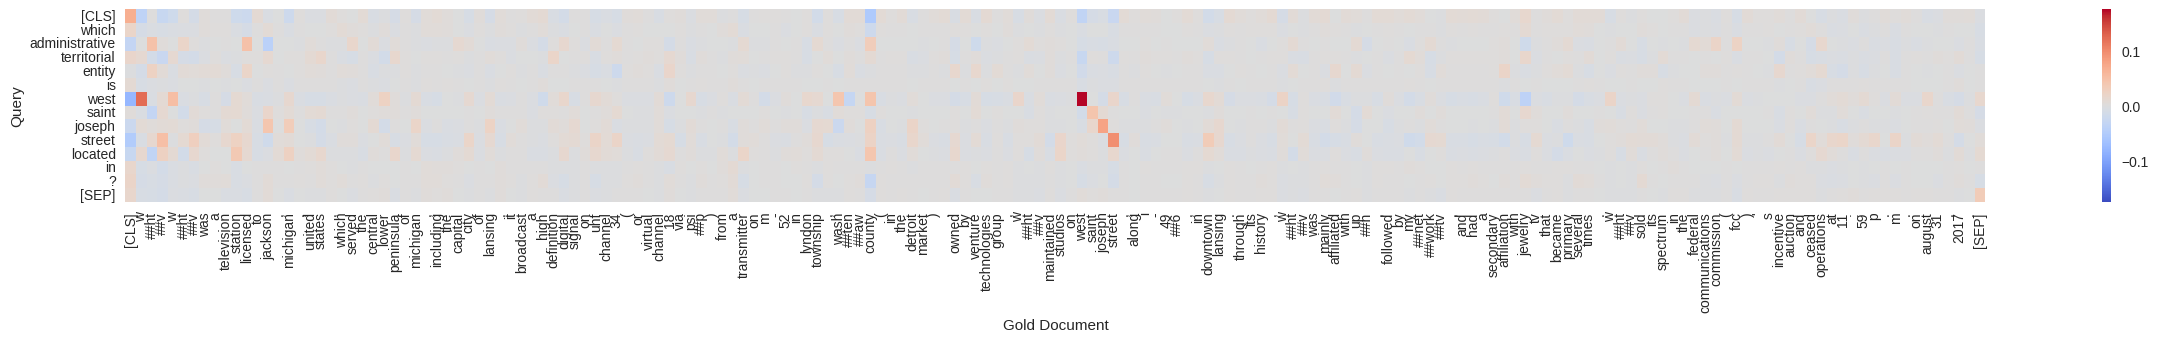

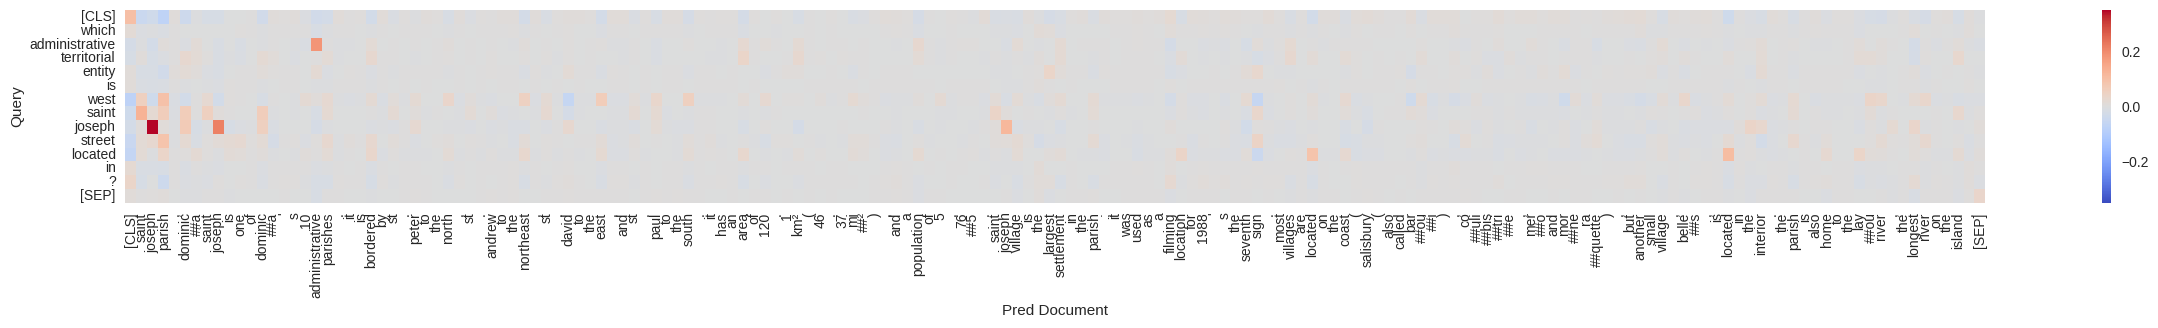

GD
tensor(0.0176) tensor(0.5939) tensor(0.1112) tensor(0.0803) tensor(0.1006) tensor(101) tensor(2)
tensor(101) tensor(2)
tensor([0.3875, 0.4086, 0.5939, 0.4617, 0.2100, 0.3068, 0.2525, 0.1215, 0.0958,
        0.2075])
Q
tensor(0.1759) tensor(1.7997) tensor(0.7355) tensor(0.6888) tensor(0.4541) tensor(5) tensor(6)
tensor(5) tensor(6)
tensor([0.6479, 0.2980, 0.9756, 0.8261, 0.8365, 0.1759, 1.7997, 0.6888, 0.9910,
        1.3198])


In [5]:
def plot_demo(df, idx):
    ### RUN/LOAD DECOMPX ON QUERY AND DOC
    query = {
        "tokens": df.loc[idx]["query_decompx_tokens"],
        "tokens_dot_scores": df.loc[idx]["query_decompx_tokens_dot_scores"],
        "decompx_last_layer_pooled": df.loc[idx]["query_decompx_decompx_last_layer_pooled"],
        "tokenizer_word_ids": df.loc[idx]["query_decompx_tokenizer_word_ids"],
        "cls_or_mean_pooled": df.loc[idx]["query_decompx_cls_or_mean_pooled"],
    }
    gold_doc = {
        "tokens": df.loc[idx]["gold_doc_decompx_tokens"],
        "tokens_dot_scores": df.loc[idx]["gold_doc_decompx_tokens_dot_scores"],
        "decompx_last_layer_pooled": df.loc[idx]["gold_doc_decompx_decompx_last_layer_pooled"],
        "tokenizer_word_ids": df.loc[idx]["gold_doc_decompx_tokenizer_word_ids"],
        "cls_or_mean_pooled": df.loc[idx]["gold_doc_decompx_cls_or_mean_pooled"],
    }
    pred_doc = {
        "tokens": df.loc[idx]["pred_doc_decompx_tokens"],
        "tokens_dot_scores": df.loc[idx]["pred_doc_decompx_tokens_dot_scores"],
        "decompx_last_layer_pooled": df.loc[idx]["pred_doc_decompx_decompx_last_layer_pooled"],
        "tokenizer_word_ids": df.loc[idx]["pred_doc_decompx_tokenizer_word_ids"],
        "cls_or_mean_pooled": df.loc[idx]["pred_doc_decompx_cls_or_mean_pooled"],
    }
    head_entity = df.loc[idx]['head_entity_longest_name'] if 'head_entity_longest_name' in df.columns else '?'
    tail_entity = df.loc[idx]['tail_entity_longest_name'] if 'tail_entity_longest_name' in df.columns else '?'
    relation = df.loc[idx]['relation_name'] if 'relation_name' in df.columns else '?'
    split = df.loc[idx]['split'] if 'split' in df.columns else '?'
    
    ### PLOT MEAN DOT IMPORTANCE
    DATASET = df.attrs.get("dataset", "?")
    MODEL = df.attrs.get("model", "?")
    htmls = [print_importance(query["tokens_dot_scores"], query["tokens"])]
    final_html = html_wrapper(htmls, "Query", f"{DATASET}, {MODEL}, idx={idx}, (head={head_entity}, relation={relation}, tail={tail_entity})")
    display(HTML(final_html))
    htmls = [print_importance(gold_doc["tokens_dot_scores"], gold_doc["tokens"])]
    final_html = html_wrapper(htmls, "Gold Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['gold_doc_score']}, hit_rank={df.loc[idx]['hit_rank']}")
    display(HTML(final_html))
    htmls = [print_importance(pred_doc["tokens_dot_scores"], pred_doc["tokens"])]
    final_html = html_wrapper(htmls, "Pred Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['pred_doc_score']}")
    display(HTML(final_html))
    
    # print("LENS", len(query["tokens"]), len(gold_doc["tokens"]), len(pred_doc["tokens"]))
    
    ### PLOT CROSS DOT IMPORTANCE
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_qd_heatmap(query_tokens, query_decomposed, doc_tokens, doc_decomposed, xlabel="Doc", ylabel="Query", ignore_cls=False):
        with torch.no_grad():
            # qd_scores = torch.einsum("id,jd->ij", torch.nn.functional.normalize(torch.tensor(query_decomposed)), torch.nn.functional.normalize(torch.tensor(doc_decomposed))).cpu().numpy()
            qd_scores = torch.einsum("id,jd->ij", torch.tensor(query_decomposed), torch.tensor(doc_decomposed)).cpu().numpy()
            # print("qd_scores.min()", qd_scores.min())
            # print("qd_scores.max()", qd_scores.max())
            # print("qd_scores.mean()", qd_scores.mean())
            # print("qd_scores.median()", np.median(qd_scores))
            # print("qd_scores.std()", qd_scores.std())
            if ignore_cls:
                qd_scores = qd_scores[1:, 1:]
                query_tokens = query_tokens[1:]
                doc_tokens = doc_tokens[1:]
        plt.figure(figsize=(30, 2.5))  # 30 for debug 15 for aesthetics
        heatmap(qd_scores, cmap=plt.get_cmap('coolwarm'), vmin=-np.max(np.abs(qd_scores)), vmax=np.max(np.abs(qd_scores)))
        plt.xticks(np.arange(len(doc_tokens))+0.5, doc_tokens, rotation='vertical')
        plt.yticks(np.arange(len(query_tokens))+0.5, query_tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.show()
    
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_pooled"], gold_doc["tokens"], gold_doc["decompx_last_layer_pooled"], "Gold Document")
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_pooled"], pred_doc["tokens"], pred_doc["decompx_last_layer_pooled"], "Pred Document")
    
    # print('gold_doc["decompx_last_layer_pooled"].sum(axis=0)[:10]\n', gold_doc["decompx_last_layer_pooled"].sum(axis=0)[:10])
    # print('gold_doc["cls_or_mean_pooled"][:10]\n', gold_doc["cls_or_mean_pooled"][:10])
    print("GD")
    n = torch.norm(torch.tensor(gold_doc["decompx_last_layer_pooled"]), dim=-1)
    print(n.min(), n.max(), n.mean(), n.median(), n.std(), n.argmin(), n.argmax())
    print(n.argmin(), n.argmax())
    print(n[:10])
    
    print("Q")
    n = torch.norm(torch.tensor(query["decompx_last_layer_pooled"]), dim=-1)
    print(n.min(), n.max(), n.mean(), n.median(), n.std(), n.argmin(), n.argmax())
    print(n.argmin(), n.argmax())
    print(n[:10])
    ### PLOT SELF DECOMPX BLOCKS
    # from seaborn import heatmap
    # import matplotlib.pyplot as plt
    
    # def plot_decompx_heatmap(tokens, decompx_last_layer_outputs, label="?"):
    #     norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
    #     heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)), cmap=plt.get_cmap('Reds'))
    #     plt.xticks(np.arange(len(tokens))+0.5, tokens, rotation='vertical')
    #     plt.yticks(np.arange(len(tokens))+0.5, tokens, rotation='horizontal')
    #     plt.grid("on", linewidth=0.2); plt.xlabel(label); plt.ylabel(label)
    
    # plt.figure(figsize=(11, 3))
    # plt.subplot(1, 3, 1); plot_decompx_heatmap(query["tokens"], query["decompx_last_layer_outputs"], "Query")
    # plt.subplot(1, 3, 2); plot_decompx_heatmap(gold_doc["tokens"], gold_doc["decompx_last_layer_outputs"], "Gold Document")
    # plt.subplot(1, 3, 3); plot_decompx_heatmap(pred_doc["tokens"], pred_doc["decompx_last_layer_outputs"], "Pred Document")
    # plt.tight_layout()

plot_demo(df_raw, idx=50)  # 329, 1526

In [6]:
df_raw.sort_values("gold_doc_len").head(20).sample(frac=1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
6977,validation15467,Who is a cast member of Epitaph?,[Ko Joo-yeon],{'Ko Joo-yeon': {'text': 'Ko Joo - yeon ( born...,"{'len': 1000, 'max': 1.1792773008346558, 'min'...",{'Ko Joo-yeon': 1.1792773008346558},"{'Ko Joo-yeon': 1.1792773008346558, 'List of p...",{'Ko Joo-yeon': {'text': 'Ko Joo - yeon ( born...,validation15467,Ko Joo-yeon,"[[{'name': 'Ko Joo-yeon', 'pos': [0, 4], 'sent...","[{'r': 'P569', 'h': 0, 't': 1, 'evidence': [0]...","[[Ko, Joo, -, yeon, (, born, February, 22, ,, ...",validation,"{'r': 'P161', 'h': 10, 't': 0, 'evidence': [1]}",15,"[{'name': 'Epitaph', 'pos': [8, 9], 'sent_id':...","[{'name': 'Ko Joo-yeon', 'pos': [0, 4], 'sent_...",{Epitaph},{Ko Joo-yeon},Epitaph,Ko Joo-yeon,{MISC},{PER},[1],"[[In, 2007, she, appeared, in, the, horror, fi...","[{'name': 'Epitaph', 'pos': [8, 9], 'sent_id':...",[],P161,cast member,Who is a cast member of Epitaph?,0,{},1.0,"Ko Joo-yeon Ko Joo - yeon ( born February 22 ,...",Ko Joo-yeon,"Ko Joo - yeon ( born February 22 , 1994 ) is a...",1.179277,"Ko Joo-yeon Ko Joo - yeon ( born February 22 ,...",Ko Joo-yeon,"Ko Joo - yeon ( born February 22 , 1994 ) is a...",1.179277,131,131,"[[CLS], who, is, a, cast, member, of, ep, ##it...","[None, 0, 1, 2, 3, 4, 5, 6, 6, 6, 6, None]","[-0.026651224, -0.012155609, -0.0012821928, -0...","[-0.6265987, 0.14081115, -0.09294612, -0.16695...","[[0.011456321, 0.0025738706, 0.010785694, -0.0...","[[CLS], ko, joo, -, ye, ##on, ko, joo, -, ye, ...","[None, 0, 1, 1, 1, 1, 2, 3, 4, 5, 5, 6, 7, 8, ...","[-0.09641468, 0.00087304076, 0.115377545, 0.13...","[-0.38726878, 0.29790923, 0.19623598, 0.020599...","[[0.02174871, 0.014624797, -0.002919728, -0.00...","[[CLS], ko, joo, -, ye, ##on, ko, joo, -, ye, ...","[None, 0, 1, 1, 1, 1, 2, 3, 4, 5, 5, 6, 7, 8, ...","[-0.09641468, 0.00087304076, 0.115377545, 0.13...","[-0.38726878, 0.29790923, 0.19623598, 0.020599...","[[0.02174871, 0.014624797, -0.002919728, -0.00..."
2431,test11116,Which administrative territorial entity is Sea...,[Mount Garibaldi],{'Mount Garibaldi': {'text': 'Mount Garibaldi ...,"{'len': 1000, 'max': 1.247523307800293, 'min':...",{'Mount Garibaldi': 0.9739065170288086},"{'Faroe Islands': 1.247523307800293, 'Sky Zone...",{'Faroe Islands': {'text': 'The Faroe Islands ...,test11116,Mount Garibaldi,"[[{'name': 'Mount Garibaldi', 'pos': [0, 2], '...","[{'r': 'P131', 'h': 1, 't': 2, 'evidence': [0]...","[[Mount, Garibaldi, is, a, potentially, active...",test,"{'h': 1, 't': 4, 'r': 'P131', 'evidence': [0]}",48,"[{'name': 'Sea to Sky Country', 'pos': [9, 13]...","[{'name': 'Canada', 'pos': [24, 25], 'sent_id'...",{Sea to Sky Country},{Canada},Sea to Sky Country,Canada,{LOC},{LOC},[0],"[[Mount, Garibaldi, is, a, potentially, active...","[{'name': 'Sea to Sky Country', 'pos': [9, 13]...","[{'name': 'Canada', 'pos': [24, 25], 'sent_id'...",P131,located in the administrative territorial entity,Which administrative ter

# Real-Time DecompX (Can Skip)

In [7]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
import transformers
from transformers import AutoTokenizer, AutoConfig

from DecompX.src.decompx_utils import DecompXConfig
from DecompX.src.modeling_bert import BertForSequenceClassification, BertModel
from DecompX.src.modeling_roberta import RobertaForSequenceClassification, RobertaModel

DATASET = df_raw.attrs.get("dataset", "?")
MODEL = df_raw.attrs.get("model", "?")  # 'facebook/contriever-msmarco'  # Only BERT or RoBERTa
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIGS = {
    "DecompX":
        DecompXConfig(
            include_biases=True,
            bias_decomp_type="absdot",
            include_LN1=True,
            include_FFN=True,
            FFN_approx_type="GeLU_ZO",
            include_LN2=True,
            aggregation="vector",
            include_classifier_w_pooler=True,
            tanh_approx_type="ZO",
            output_all_layers=True,
            output_attention=None,
            output_res1=None,
            output_LN1=None,
            output_FFN=None,
            output_res2=None,
            output_encoder=None,
            output_aggregated="vector",  # Changed
            output_pooler="norm",
            output_classifier=True,
        ),
}

def load_model_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_config = AutoConfig.from_pretrained(model_name)
    if type(model_config) is transformers.models.roberta.configuration_roberta.RobertaConfig:
        model = RobertaModel.from_pretrained(model_name)
    elif type(model_config) is transformers.models.bert.configuration_bert.BertConfig:
        model = BertModel.from_pretrained(model_name)
    else:
        raise Exception(f"Not implemented model: {model_name}")
    model.to(DEVICE)
    return model, tokenizer

model, tokenizer = load_model_tokenizer(MODEL)

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
def run_decompx(text, model, pooling):
    text = text.split()
    inputs = tokenizer([text], padding=True, truncation=True, return_tensors='pt', is_split_into_words=True, max_length=512)
    input_ids = inputs["input_ids"]
    inputs.to(model.device)
    with torch.no_grad():
        last_hidden_states, pooler_output, hidden_states, decompx_last_layer_outputs, decompx_all_layers_outputs = model(
            **inputs,
            output_attentions=False,
            return_dict=False,
            output_hidden_states=True,
            decompx_config=CONFIGS["DecompX"]
        )
        ### decompx_last_layer_outputs.aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim] ###
        ### last_hidden_states ~ [1, 70, 768] ~ [batch, seq_len, emb_dim]
        # print(last_hidden_states.shape)  # 
        if pooling == "avg":
            cls_or_mean_pooled = last_hidden_states[0].mean(dim=0)
            decompx_last_layer_pooled = decompx_last_layer_outputs.aggregated[0][0].mean(dim=(0))  # Mean over DecompX similar to the retriever [seq_len, emb_dim]
            # assert torch.allclose(cls_or_mean_pooled, decompx_last_layer_pooled.sum(dim=0), atol=1e-3)
            tokens_dot_scores = torch.einsum("ij,j->i", decompx_last_layer_pooled, cls_or_mean_pooled)  # [seq_len]
        elif pooling == "cls":
            cls_or_mean_pooled = last_hidden_states[0][0]
            decompx_last_layer_pooled = decompx_last_layer_outputs.aggregated[0][0][0]  # Choose CLS decompx similar to the retriever [seq_len, emb_dim]
            # assert torch.allclose(cls_or_mean_pooled, decompx_last_layer_pooled.sum(dim=0), atol=1e-3)
            tokens_dot_scores = torch.einsum("ij,j->i", decompx_last_layer_pooled, cls_or_mean_pooled)  # [seq_len]
        else:
            raise ValueError("Pooling method not supported")
        ranking = torch.argsort(tokens_dot_scores, descending=True).cpu().numpy()
    return {
        "tokens": tokenizer.convert_ids_to_tokens(input_ids[0]),  # [seq_len]
        "tokenizer_word_ids": inputs.word_ids(),  # [seq_len]
        
        "cls_or_mean_pooled": cls_or_mean_pooled.cpu().numpy(),  # [emb_dim]
        "tokens_dot_scores": tokens_dot_scores.cpu().numpy(),  # [seq_len]  (Dot score with mean/cls)
        "decompx_last_layer_pooled": decompx_last_layer_pooled.cpu().numpy(),  # [seq_len, emb_dim]
        # "decompx_last_layer_outputs": decompx_last_layer_outputs.aggregated[0][0].cpu().numpy(),  # .aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim]
    }

# Finding Tokenized Position of Entities

In [10]:
from unidecode import unidecode

def find_head_tail_tokens(df, idx, verbose=False):
    def vprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    ### Load Tokenizer
    # tokenizer = AutoTokenizer.from_pretrained("facebook/contriever-msmarco")
    ### RUN/LOAD DECOMPX ON QUERY AND DOC
    query = {
        "tokens": np.array(df.loc[idx]["query_decompx_tokens"]),
        "tokens_dot_scores": df.loc[idx]["query_decompx_tokens_dot_scores"],
        "decompx_last_layer_pooled": df.loc[idx]["query_decompx_decompx_last_layer_pooled"],
        "tokenizer_word_ids": df.loc[idx]["query_decompx_tokenizer_word_ids"],
    }
    gold_doc = {
        "tokens": np.array(df.loc[idx]["gold_doc_decompx_tokens"]),
        "tokens_dot_scores": df.loc[idx]["gold_doc_decompx_tokens_dot_scores"],
        "decompx_last_layer_pooled": df.loc[idx]["gold_doc_decompx_decompx_last_layer_pooled"],
        "tokenizer_word_ids": df.loc[idx]["gold_doc_decompx_tokenizer_word_ids"],
    }
    # gold_doc = run_decompx(df.loc[idx]["gold_doc"])
    # gold_doc["tokens"] = np.array(gold_doc["tokens"])
    
    # pred_doc = {
    #     "tokens": df.loc[idx]["pred_doc_decompx_tokens"],
    #     "tokens_dot_scores": df.loc[idx]["pred_doc_decompx_tokens_dot_scores"],
    #     "decompx_last_layer_mean": df.loc[idx]["pred_doc_decompx_decompx_last_layer_mean"],
    #     "tokenizer_word_ids": df.loc[idx]["pred_doc_decompx_tokenizer_word_ids"],
    # }
    sent_len_accumulated = [0]
    for sent in df.loc[idx]["sents"]:
        sent_len_accumulated.append(len(sent) + sent_len_accumulated[-1])
        
    words = np.array([w for sent in df.loc[idx]["sents"] for w in sent])
    tokenizer_skipped_chars = [" ", '\xa0']
    hyphen_chars_accumulated = [1 if words[0] in tokenizer_skipped_chars else 0]
    for w in words[1:]:
        hyphen_chars_accumulated.append(hyphen_chars_accumulated[-1] + 1 if w in tokenizer_skipped_chars else hyphen_chars_accumulated[-1])
    # vprint("hyphen_chars_accumulated", hyphen_chars_accumulated, len(hyphen_chars_accumulated))
    # vprint("words", words, len(words))
    # title_len = max(tokenizer([df.loc[idx]["title"]], padding=False, truncation=True, return_tensors='pt').word_ids()[1:-1]) + 1
    title_len = len(df.loc[idx]["title"].split())
    
    def find_entity(entity):
        global_pos = np.array([
            sent_len_accumulated[entity["sent_id"]] + entity["pos"][0], 
            sent_len_accumulated[entity["sent_id"]] + entity["pos"][1]
        ])
        
        # assert " ".join(words[global_pos[0]:global_pos[1]]) == entity["name"]
        if " ".join(words[global_pos[0]:global_pos[1]]).replace(" ", "") != entity["name"].replace(" ", ""):
            print(f"{idx} WARNING1:", " ".join(words[global_pos[0]:global_pos[1]]), "!=", entity["name"])
        
        ### FIX \xa0 and ' '
        global_pos[0] -= hyphen_chars_accumulated[global_pos[0]]
        global_pos[1] -= hyphen_chars_accumulated[global_pos[1] - 1]
        ### FIX TITLE
        global_pos += title_len
        
        tokenizer_word_ids = np.array(gold_doc["tokenizer_word_ids"])
        tokenizer_word_ids[tokenizer_word_ids == None] = -1
        # vprint("tokenizer_word_ids, global_pos", tokenizer_word_ids, global_pos)
        token_pos = np.where(np.logical_and(tokenizer_word_ids>=global_pos[0], tokenizer_word_ids<global_pos[1]))[0]
        # print("head_token_pos", head_token_pos)
        # vprint("tokens", gold_doc["tokens"])
        # vprint(entity)
        # vprint("\n####tokens selected", gold_doc["tokens"][token_pos], "\n\n")
        
        a = []; b = []
        for word_id, token in zip(tokenizer_word_ids, gold_doc["tokens"]):
            a.append(f"[{word_id}]{token}")
        for i, w in enumerate(words):
            b.append(f"[{i + title_len}]{w}")
        # vprint(np.array(b))
        # vprint(np.array(a))
        
        # assert("".join(gold_doc["tokens"][token_pos]).lower().replace("#", "") == entity["name"].replace(" ", "").lower())
        if unidecode("".join(gold_doc["tokens"][token_pos]).lower().replace("#", "")) != unidecode(entity["name"].replace(" ", "").replace("\xa0", "").lower()):
            print(f"{idx} WARNING2:", "".join(gold_doc["tokens"][token_pos]).lower().replace("#", ""), "!=", entity["name"].replace(" ", "").replace("\n", "").lower(), len(words))
        return token_pos
    
    def find_query_head_tokens(row):
        def find_sub_list(sl,l):
            results=[]
            sll=len(sl)
            for ind in (i for i,e in enumerate(l) if e==sl[0]):
                if l[ind:ind+sll]==sl:
                    results.append((ind,ind+sll))
            return results
        vprint(row["query"])
        head_in_query_str_list = row["head_entity_longest_name"].split()
        query_str_list = row["query"].replace("?", "", 1).split()  # "when was head?" and head can have ? in itself! idx=6270
        vprint("head_in_query_str_list", head_in_query_str_list)
        vprint("query_str_list", query_str_list)
        query_head_pos = find_sub_list(head_in_query_str_list, query_str_list)[0]
        vprint("query_head_pos", query_head_pos)
        tokenizer_word_ids = np.array(query["tokenizer_word_ids"])
        tokenizer_word_ids[tokenizer_word_ids == None] = -1
        token_pos = np.where(np.logical_and(tokenizer_word_ids>=query_head_pos[0], tokenizer_word_ids<query_head_pos[1]))[0]
        if query["tokens"][token_pos[-1]] == "?":
            token_pos = token_pos[:-1]
        vprint("token_pos", token_pos)
        vprint("tokens", query["tokens"])
        vprint("word_ids", tokenizer_word_ids)
        vprint(query["tokens"][token_pos])
        if unidecode("".join(query["tokens"][token_pos]).lower().replace("#", "")) != unidecode(row["head_entity_longest_name"].replace(" ", "").replace("\xa0", "").lower()):
            print(f"{idx} WARNING2:", unidecode("".join(query["tokens"][token_pos]).lower().replace("#", "")), "!=", unidecode(row["head_entity_longest_name"].replace(" ", "").replace("\xa0", "").lower()))
        return token_pos
        
    
    head_global_pos = []
    tail_global_pos = []
    for head_entity in df.loc[idx]['head_entity']:
        head_global_pos.extend(find_entity(head_entity))
    for tail_entity in df.loc[idx]['tail_entity']:  # in evidence or not?
        tail_global_pos.extend(find_entity(tail_entity))
    
    return {
        "heads_pos": head_global_pos,
        "tails_pos": tail_global_pos,
        "query_head_pos": find_query_head_tokens(df.loc[idx])
    }
    
    
find_head_tail_tokens(df_raw, 6270, verbose=True)  # 1526

Who performed Is It True ??
head_in_query_str_list ['Is', 'It', 'True', '?']
query_str_list ['Who', 'performed', 'Is', 'It', 'True', '?']
query_head_pos (2, 6)
token_pos [3 4 5 6]
tokens ['[CLS]' 'who' 'performed' 'is' 'it' 'true' '?' '?' '[SEP]']
word_ids [-1 0 1 2 3 4 5 5 -1]
['is' 'it' 'true' '?']


{'heads_pos': [np.int64(186), np.int64(187), np.int64(188), np.int64(189)],
 'tails_pos': [np.int64(181), np.int64(182), np.int64(183)],
 'query_head_pos': array([3, 4, 5, 6])}

In [11]:
### ADD HEAD AND TAIL AND QUERY_HEAD TOKEN POSITIONS TO THE DATAFRAME
df = df_raw.copy()
new_cols = {}
for idx in tqdm(range(len(df))):
    head_tail_pos = find_head_tail_tokens(df_raw, idx, verbose=False)
    for k, v in head_tail_pos.items():
        new_cols[k] = new_cols.get(k, []) + [v]
for k, v in new_cols.items():
    print("NEW COLUMN:", k)
    df[k] = v

# Remove empty heads and tails (Only 1 case)
df = df[df["heads_pos"].str.len() > 0]
df = df[df["tails_pos"].str.len() > 0]

df

  0%|          | 0/7170 [00:00<?, ?it/s]

68 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
68 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
69 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
69 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
70 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
70 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
71 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
71 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
77 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
77 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
319 WARNING2:  != spacex 474
320 WARNING2:  != spacex 474
421 WARNING2: 江[unk][unk] != 江采蘋 423
717 WARNING2: [unk] != ადამაშვილი 159
718 WARNING2: [unk] != ადამაშვილი 159
1083 WARNING1: Live in New York != 0.
Live in New York
1083 WARNING2: liveinnewyork != 0.liveinnewyork 254
1083 WARNING2: 0.liveinnewyork != 0.
livei

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,heads_pos,tails_pos,query_head_pos
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 213.948486328125, 'min': ...",{'Loud Tour': 213.948486328125},"{'Loud Tour': 213.948486328125, 'Talking Loud ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,213.948486,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,213.948486,142,142,"[[CLS], when, was, loud, tour, published, ?, [...","[None, 0, 1, 2, 3, 4, 4, None]","[0.0047527365, -0.05765076, 0.057680156, -0.05...","[119.4733, 12.401355, -1.6081847, 24.130854, 2...","[[-0.06965925, 0.05920578, -0.046958648, 0.097...","[[CLS], loud, tour, the, loud, tour, was, the,...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[0.17675242, -0.16014594, 0.13842197, -0.04156...","[60.105556, 8.144972, 3.3149285, 3.6852744, 8....","[[0.0124732945, 0.029028766, 0.0089176, 0.0582...","[[CLS], loud, tour, the, loud, tour, was, the,...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[0.17675242, -0.16014594, 0.13842197, -0.04156...","[60.105556, 8.144972, 3.3149285, 3.6852744, 8....","[[0.0124732945, 0.029028766, 0.0089176, 0.0582...","[47, 142, 143, 4, 5, 75, 76]",[49],"[3, 4]"
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 216.81773376464844, 'min'...",{'Loud Tour': 216.81773376464844},"{'Loud Tour': 216.81773376464844, 'Live &amp; ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud Tour, Loud}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [18, 19], 'sent_id...",P175,performer,Who performed Loud Tour?,0,{},1.0,Loud Tour The L

In [13]:
### MAX AND SUM HEAD TAIL ATTN
qd_op = np.sum
head_tail_op = np.sum
all_tokens_op = np.sum
divide = False


# df["qd_scores"] = df.apply(lambda row: torch.einsum("id,jd->ij", torch.nn.functional.normalize(torch.tensor(row["query_decompx_decompx_last_layer_pooled"])), torch.nn.functional.normalize(torch.tensor(row["gold_doc_decompx_decompx_last_layer_pooled"]))).cpu().numpy(), axis=1)

df["qd_scores"] = df.apply(lambda row: torch.einsum("id,jd->ij", torch.tensor(row["query_decompx_decompx_last_layer_pooled"]), torch.tensor(row["gold_doc_decompx_decompx_last_layer_pooled"])).cpu().numpy(), axis=1)
df["qd_scores_op"] = df.apply(lambda row: qd_op(row["qd_scores"], axis=0), axis=1)

df["qd_scores_head"] = df.apply(lambda row: qd_op(row["qd_scores"][row["query_head_pos"], :], axis=0), axis=1)
# df["qd_scores_head"] = df.apply(lambda row: qd_op(row["qd_scores"][row["query_head_pos"], 1:], axis=0), axis=1)  # Ignore [CLS]

df["qd_scores_relation"] = df.apply(lambda row: qd_op(np.delete(row["qd_scores"], row["query_head_pos"], axis=0)[1:-1], axis=0), axis=1)
print(df.iloc[0]["qd_scores_head"].shape, df.iloc[0]["qd_scores_relation"].shape)

if divide:
    df["heads_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["heads_pos"]]) / all_tokens_op(row["qd_scores_op"]), axis=1)
    df["tails_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["tails_pos"]]) / all_tokens_op(row["qd_scores_op"]), axis=1)
    df["heads_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["heads_pos"]]) / all_tokens_op(row["gold_doc_decompx_tokens_dot_scores"]), axis=1)
    df["tails_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["tails_pos"]]) / all_tokens_op(row["gold_doc_decompx_tokens_dot_scores"]), axis=1)
    df["query_head_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_head"]) / all_tokens_op(row["qd_scores_op"]), axis=1)
    df["query_relation_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_relation"]) / all_tokens_op(row["qd_scores_op"]), axis=1)
else:
    
    df["heads_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["heads_pos"]]), axis=1)
    df["tails_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["tails_pos"]]), axis=1)
    df["heads_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["heads_pos"]]), axis=1)
    df["tails_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["tails_pos"]]), axis=1)
    df["query_head_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_head"]), axis=1)
    df["query_relation_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_relation"]), axis=1)

df
for s in ["heads_attn_qd", "tails_attn_qd"]:
    print("Dropped Outliers:", len(df[df[s] < -100]))
    df = df[df[s] > -100]

(155,) (155,)
Dropped Outliers: 0
Dropped Outliers: 0


# CORR: Gold Doc Score vs head/tail/relation attn

<Figure size 600x400 with 0 Axes>

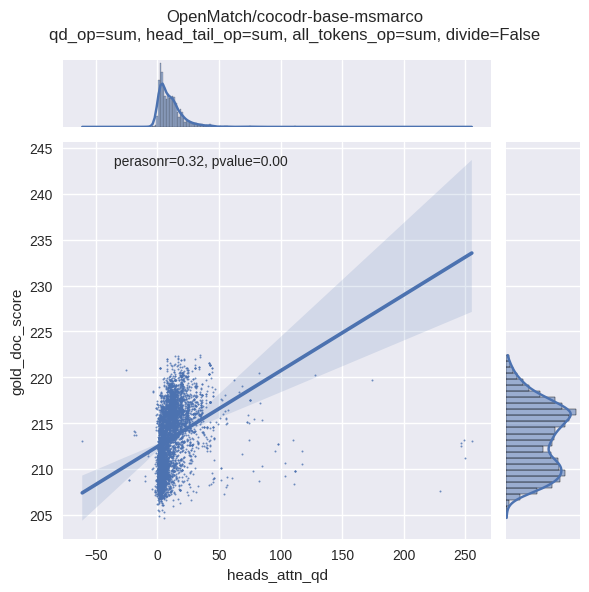

<Figure size 600x400 with 0 Axes>

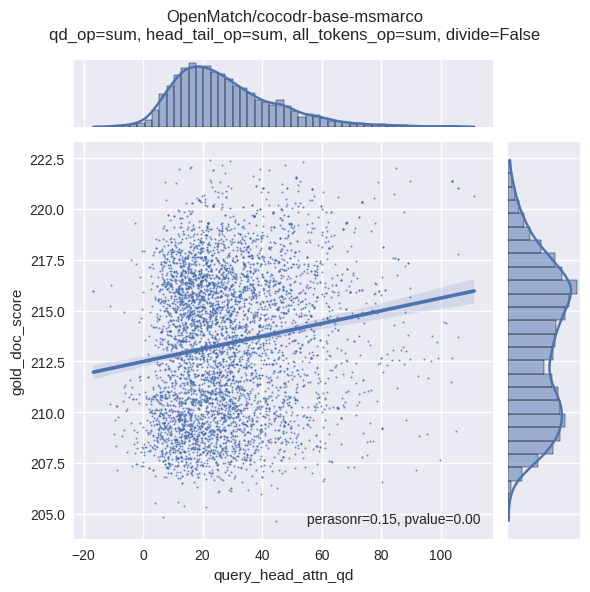

<Figure size 600x400 with 0 Axes>

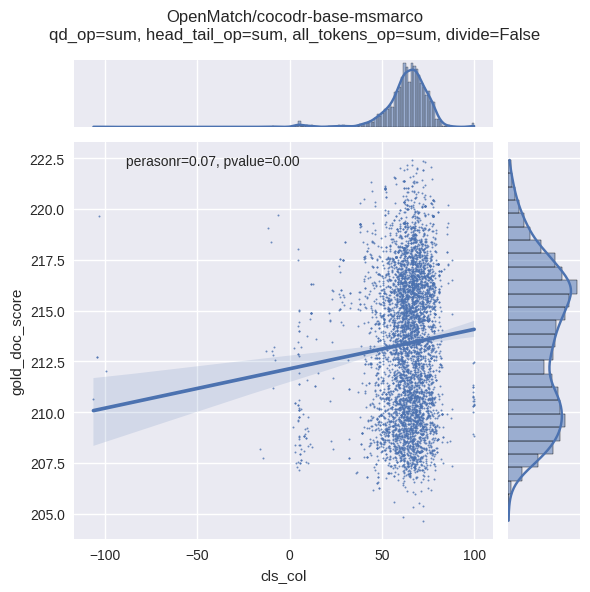

In [18]:
### CORR: Gold Doc Score vs head/tail/relation attn

dfc = df.copy()
dfc["hit_rank_quantized"] = dfc["hit_rank"].apply(lambda x: 0 if x < 5 else 1 if x <= 50 else 2 if x <= 100 else 3)
# dfc = dfc[["tails_attn_qd", "heads_attn_qd", "gold_doc_score"]]
# dfc.fillna(0, inplace=True)
dfc.dropna(inplace=True)
# dfc.plot.scatter(y="gold_doc_score", x="tails_attn_qd", figsize=(6, 4), s=0.1, xlim=(-0.1, 0.3))
# dfc.plot.scatter(y="gold_doc_score", x="heads_attn_qd", figsize=(6, 4), s=0.1, c="hit_rank_quantized")
# sns.scatterplot(data=dfc, y="gold_doc_score", x="heads_attn_qd", hue="hit_rank_quantized", s=10)
# sns.regplot(data=dfc, x="heads_attn_qd", y="gold_doc_score")

MODEL = df_raw.attrs.get("model", "?")
def plot_jointplot(dfc, x, y):
    plt.figure(figsize=(6, 4))
    g = sns.jointplot(data=dfc, x=x, y=y, kind="reg", ci=99, scatter_kws={'s': 2})
    r, p = stats.pearsonr(x=dfc[x], y=dfc[y])
    phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
    g.ax_joint.legend([phantom],[f"perasonr={r:.2f}, pvalue={p:.2f}"])
    plt.suptitle(f"{MODEL}\nqd_op={qd_op.__name__}, head_tail_op={head_tail_op.__name__}, all_tokens_op={all_tokens_op.__name__}, divide={divide}",)
    plt.tight_layout()
    plt.show()


plot_jointplot(dfc, x="heads_attn_qd", y="gold_doc_score")
# plot_jointplot(dfc, x="tails_attn_qd", y="gold_doc_score")

# plot_jointplot(dfc, x="heads_attn_selfdot", y="gold_doc_score")
# plot_jointplot(dfc, x="tails_attn_selfdot", y="gold_doc_score")

plot_jointplot(dfc, x="query_head_attn_qd", y="gold_doc_score")
# plot_jointplot(dfc, x="query_relation_attn_qd", y="gold_doc_score")

dfc["cls_col"] = dfc["qd_scores"].apply(lambda x: x[:, 0].sum())
plot_jointplot(dfc, x="cls_col", y="gold_doc_score")

# Attn BoxPlot

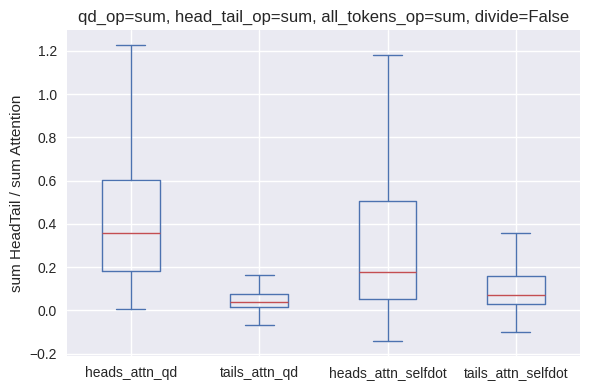

In [12]:
df[["heads_attn_qd", "tails_attn_qd", "heads_attn_selfdot", "tails_attn_selfdot"]].plot.box(
    figsize=(6, 4), 
    title=f"qd_op={qd_op.__name__}, head_tail_op={head_tail_op.__name__}, all_tokens_op={all_tokens_op.__name__}, divide={divide}",
    showfliers=False,
)
plt.ylabel(f"{head_tail_op.__name__} HeadTail / {all_tokens_op.__name__} Attention")
plt.tight_layout()
plt.show()

# Head/Tail Attn per Entity Type

In [18]:
df

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_mean,query_decompx_tokenizer_word_ids,gold_doc_decompx_tokens,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_mean,gold_doc_decompx_tokenizer_word_ids,pred_doc_decompx_tokens,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_mean,pred_doc_decompx_tokenizer_word_ids,heads_pos,tails_pos,query_head_pos,qd_scores,qd_scores_op,qd_scores_head,qd_scores_relation,heads_attn_qd,tails_attn_qd,heads_attn_selfdot,tails_attn_selfdot,query_head_attn_qd,query_relation_attn_qd
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.5781064033508301, 'min'...",{'Loud Tour': 0.5781064033508301},"{'Loud Tour': 0.5781064033508301, 'Images and ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,142,142,"[[CLS], when, was, loud, tour, published, ?, [...","[-1.010608, 0.23060957, -0.025443379, 2.001933...","[[0.05046981, -0.012882221, 0.036922462, 0.014...","[None, 0, 1, 2, 3, 4, 4, None]","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[47, 142, 143, 4, 5, 75, 76]",[49],"[3, 4]","[[0.30964455, -0.712886, -0.013142059, 0.03303...","[-0.19506332, 0.5661381, 0.1324479, -0.0176743...","[-0.77891374, 1.8093113, 0.27102107, -0.104549...","[0.58385044, -1.2431731, -0.13857315, 0.086875...",0.830905,0.013935,0.875421,0.025883,2.317676,-0.849747
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.6464771032333374, 'min'...",{'Loud Tour': 0.6464771032333374},"{'Loud Tour': 0.6464771032333374, 'Live &amp; ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud, Loud Tour}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name'

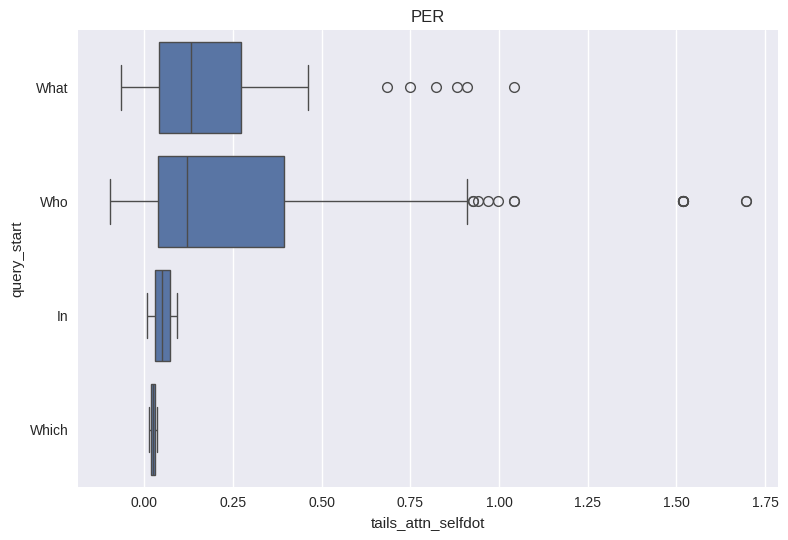

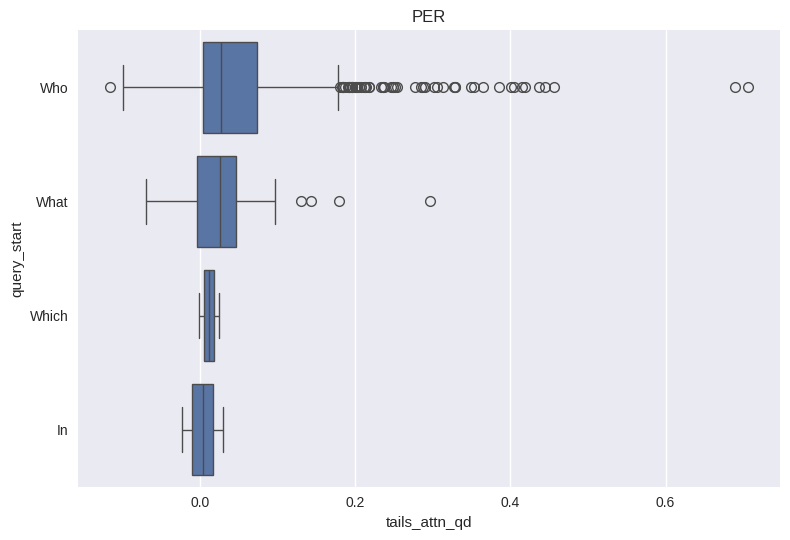

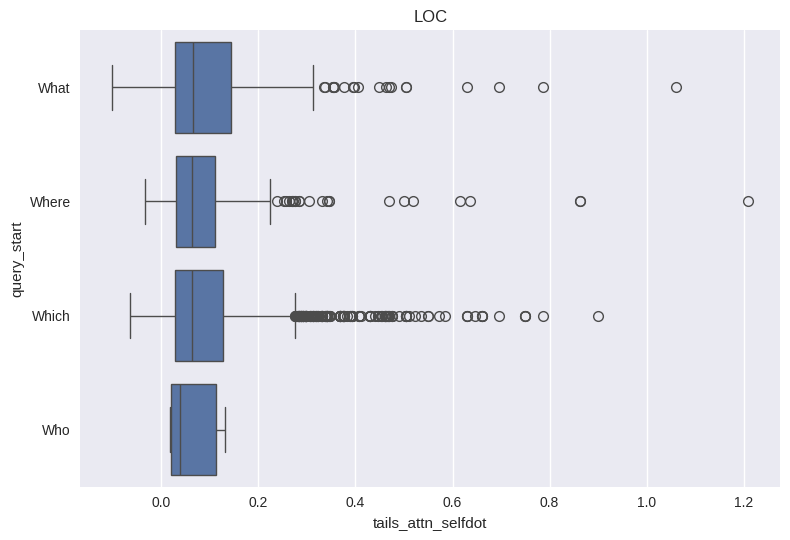

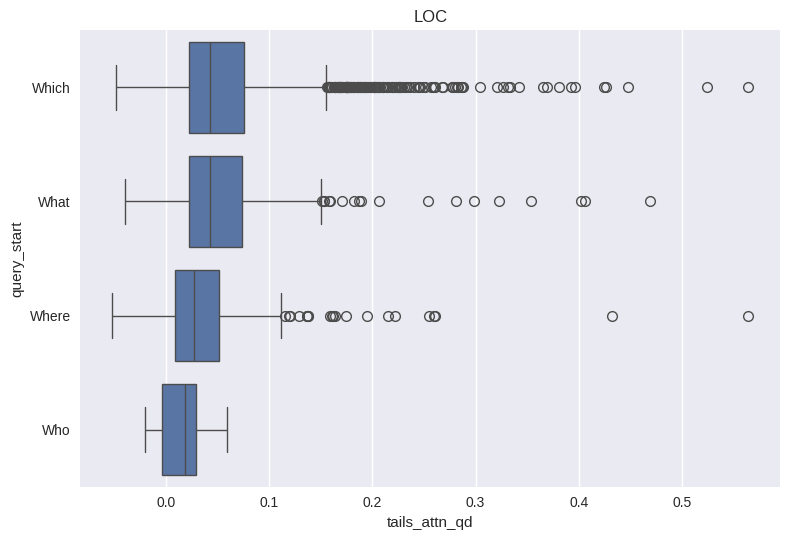

In [38]:
for r in ["PER", "LOC"]:
    df2 = df.copy()
    df2 = df2[df2["tail_entity_types"].apply(lambda x: r in x)]
    df2["query_start"] = df2["query"].apply(lambda x: " ".join(x.split()[:1]))
    # df2.plot.scatter(y="tails_attn_qd", x="tails_attn_selfdot", figsize=(6, 4), s=0.5, xlim=(-0.1, 0.6), ylim=(-0.1, 0.6))
    boxplot_ordered(df2, "query_start", "tails_attn_selfdot", True)
    plt.title(r)
    plt.tight_layout()
    plt.show()

    boxplot_ordered(df2, "query_start", "tails_attn_qd", True)
    plt.title(r)
    plt.tight_layout()
    plt.show()

# df2[["query", "gold_doc", "head_entity_names", "tail_entity_names", "tail_entity_types", "relation_name", "tails_attn_qd", "tails_attn_selfdot"]]

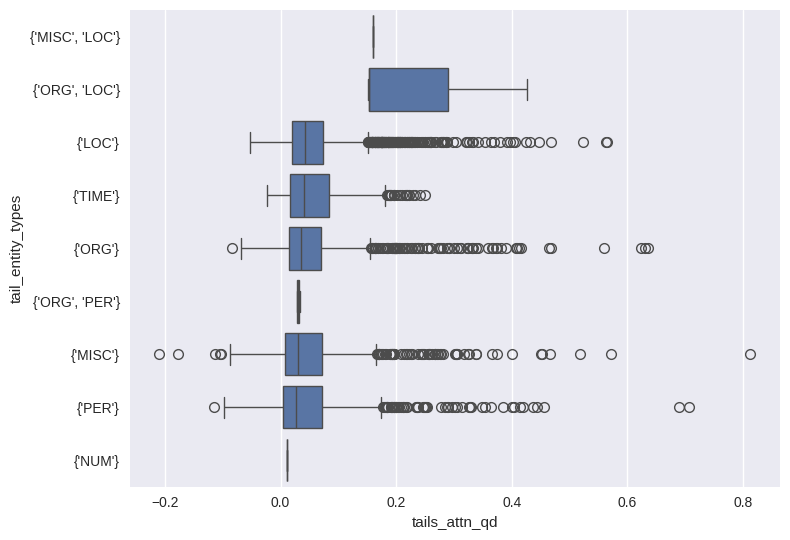

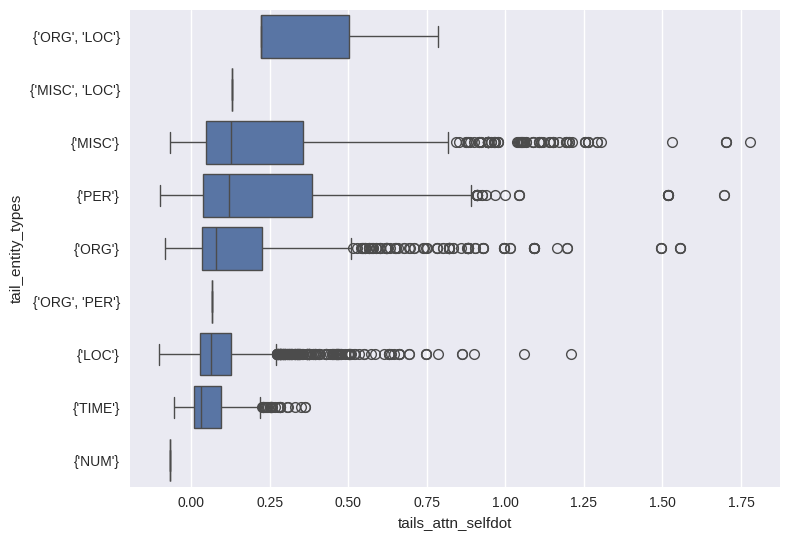

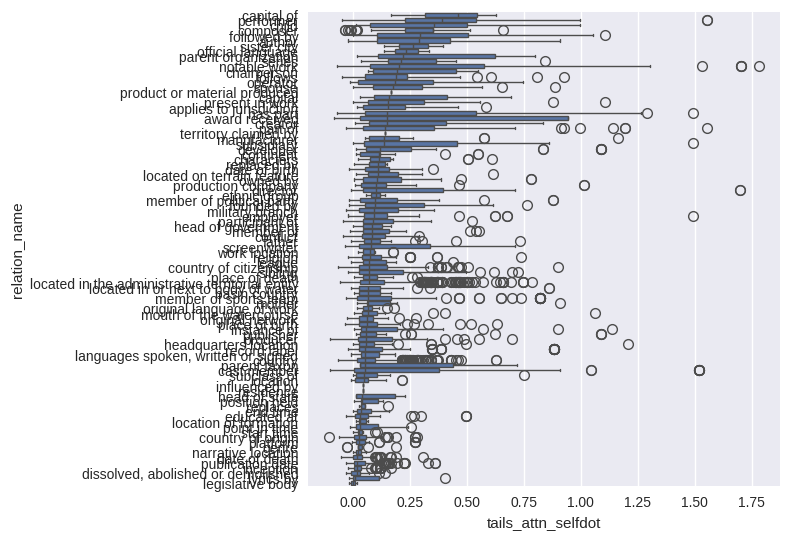

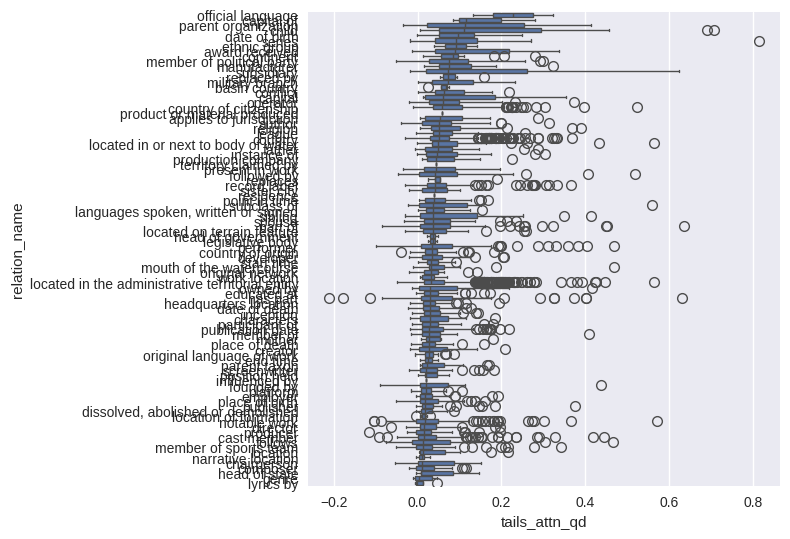

In [26]:
df2 = df[["head_entity_types", "tail_entity_types", "heads_attn_qd", "tails_attn_qd", "heads_attn_selfdot", "tails_attn_selfdot", "relation_name"]].copy()
df2["head_entity_types"] = df2["head_entity_types"].astype(str)
df2["tail_entity_types"] = df2["tail_entity_types"].astype(str)

def boxplot_ordered(dfc, x, y, rotate=False):
    grouped = dfc.loc[:,[x, y]].groupby([x]).median().sort_values(by=y, ascending=False)
    if not rotate:
        sns.boxplot(x=dfc[x], y=dfc[y], order=grouped.index)
    else:
        sns.boxplot(x=dfc[y], y=dfc[x], order=grouped.index)

# boxplot_ordered(df2, "head_entity_types", "heads_attn_qd", True)
# plt.tight_layout()
# plt.show()

boxplot_ordered(df2, "tail_entity_types", "tails_attn_qd", True)
plt.tight_layout()
plt.show()

# boxplot_ordered(df2, "head_entity_types", "heads_attn_selfdot", True)
# plt.tight_layout()
# plt.show()

boxplot_ordered(df2, "tail_entity_types", "tails_attn_selfdot", True)
plt.tight_layout()
plt.show()

boxplot_ordered(df2, "relation_name", "tails_attn_selfdot", True)
plt.tight_layout()
plt.show()

boxplot_ordered(df2, "relation_name", "tails_attn_qd", True)
plt.tight_layout()
plt.show()

# More

In [33]:
import seaborn as sns

df["head_entity_len"] = df["head_entity"].str.len()
df["tail_entity_len"] = df["tail_entity"].str.len()
sns.boxplot(data=df, x="head_entity_len", y="gold_doc_score")
plt.show()
sns.boxplot(data=df, x="tail_entity_len", y="gold_doc_score")


NameError: name 'df' is not defined

In [ ]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("OpenMatch/cocodr-base-msmarco")
tokenizer = AutoTokenizer.from_pretrained("OpenMatch/cocodr-base-msmarco") 

config.json:   0%|          | 0.00/977 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [64]:
df_raw.loc[3474]["gold_doc"]
df_raw.loc[[3474]]

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
3474,test15834,When did Georgi Dimitrov die?,[Georgi Dimitrov Mausoleum],{'Georgi Dimitrov Mausoleum': {'text': 'The Ge...,"{'len': 1000, 'max': 215.22021484375, 'min': 2...",{'Georgi Dimitrov Mausoleum': 215.22021484375},"{'Georgi Dimitrov Mausoleum': 215.22021484375,...",{'Georgi Dimitrov Mausoleum': {'text': 'The Ge...,test15834,Georgi Dimitrov Mausoleum,"[[{'type': 'LOC', 'pos': [1, 4], 'name': 'Geor...","[{'r': 'P17', 'h': 2, 't': 4, 'evidence': [0]}...","[[The, Georgi, Dimitrov, Mausoleum, (, ), was,...",test,"{'r': 'P570', 'h': 8, 't': 5, 'evidence': [1]}",4,"[{'name': 'Dimitrov', 'pos': [35, 36], 'sent_i...","[{'type': 'TIME', 'pos': [7, 8], 'name': '1949...","{Dimitrov, Georgi Dimitrov}",{1949},Georgi Dimitrov,1949,{PER},{TIME},[1],"[[The, white, marble, mausoleum, was, built, i...","[{'name': 'Dimitrov', 'pos': [35, 36], 'sent_i...","[{'type': 'TIME', 'pos': [7, 8], 'name': '1949...",P570,date of death,When did Georgi Dimitrov die?,0,{},1.0,Georgi Dimitrov Mausoleum The Georgi Dimitrov ...,Georgi Dimitrov Mausoleum,The Georgi Dimitrov Mausoleum ( ) was a ceremo...,215.220215,Georgi Dimitrov Mausoleum The Georgi Dimitrov ...,Georgi Dimitrov Mausoleum,The Georgi Dimitrov Mausoleum ( ) was a ceremo...,215.220215,287,287,"[[CLS], when, did, georg, ##i, dim, ##it, ##ro...","[None, 0, 1, 2, 2, 3, 3, 3, 4, 4, None]","[0.15241572, 0.070291735, 0.16747493, 0.282568...","[120.321976, 15.86287, 6.348073, 4.252346, -2....","[[-0.014112167, -0.027298417, 0.035229594, 0.0...","[[CLS], georg, ##i, dim, ##it, ##rov, mausoleu...","[None, 0, 0, 1, 1, 1, 2, 3, 4, 4, 5, 5, 5, 6, ...","[-0.04455067, 0.38900998, -0.03495682, 0.31511...","[-8.75257, 10.598049, 52.6613, 10.685126, 32.4...","[[-0.05153294, -0.39835295, -1.0445316, 0.3816...","[[CLS], georg, ##i, dim, ##it, ##rov, mausoleu...","[None, 0, 0, 1, 1, 1, 2, 3, 4, 4, 5, 5, 5, 6, ...","[-0.04455067, 0.38900998, -0.03495682, 0.31511...","[-8.75257, 10.598049, 52.6613, 10.685126, 32.4...","[[-0.05153294, -0.39835295, -1.0445316, 0.3816..."


In [25]:
sentences = [
    "Georgi Dimitrov Mausoleum The Georgi Dimitrov Mausoleum ( ) was a ceremonial tomb on Prince Alexander of Battenberg Square in Sofia , Bulgaria , from 1949 to 1999 . The white marble mausoleum was built in 1949 to contain the embalmed body of Bulgaria 's first Communist leader , Georgi Dimitrov ( 1882 – 1949 ) , construction beginning immediately after the news of Dimitrov 's death . It was completed in just six days , the time it took Dimitrov 's body to be returned to Sofia from the USSR . Dimitrov 's body remained in the mausoleum until August 1990 , when Dimitrov 's remains were cremated and the ashes buried in the Sofia 's Central Cemetery . The mausoleum itself was destroyed by Prime Minister Ivan Kostov 's UDF government in 1999 after a heated nationwide debate . The prime minister and his party claimed that retaining the mausoleum was inappropriate following the fall of Communism in 1989 because it represented Bulgaria 's repressive past . Even within the government there was opposition to destroying the building , and an opinion poll revealed that two - thirds of the population opposed the demolition . Proposals were made to turn the mausoleum into a museum or art gallery because it contributed to the unique atmosphere of the capital city . In August 1999 , the government made four attempts to demolish the building . The first three failed because they relied on a single powerful explosion . The building did not budge after the first two attempts and tilted only slightly after the third . The fourth ( and successful ) attempt was carried out using a series of consecutive , less powerful explosions .",
    "Georgi Dimitrov Mausoleum The Georgi Dimitrov Mausoleum ( ) was a ceremonial tomb on Prince Alexander of Battenberg Square in Sofia , Bulgaria , from 1949 to 1999 . The white marble mausoleum was built in 1949 to contain the embalmed body of Bulgaria 's first Communist leader , Georgi Dimitrov ( 1882 – 1949 ) , construction beginning immediately after the news of Dimitrov 's death . It was completed in just six days , the time it took Dimitrov 's body to be returned to Sofia from the USSR . Dimitrov 's body remained in the mausoleum until August 1990 , when remains were cremated and the ashes buried in the Sofia 's Central Cemetery . The mausoleum itself was destroyed by Prime Minister Ivan Kostov 's UDF government in 1999 after a heated nationwide debate . The prime minister and his party claimed that retaining the mausoleum was inappropriate following the fall of Communism in 1989 because it represented Bulgaria 's repressive past . Even within the government there was opposition to destroying the building , and an opinion poll revealed that two - thirds of the population opposed the demolition . Proposals were made to turn the mausoleum into a museum or art gallery because it contributed to the unique atmosphere of the capital city . In August 1999 , the government made four attempts to demolish the building . The first three failed because they relied on a single powerful explosion . The building did not budge after the first two attempts and tilted only slightly after the third . The fourth ( and successful ) attempt was carried out using a series of consecutive , less powerful explosions ."
]
q = [
    "When did Georgi Dimitrov die?"
]

q = [
    "When was Microserfs published?"
]

sentences = [
    "Microserfs , published by HarperCollins in 1995 , is an epistolary novel by Douglas Coupland .",
    "Coupland revisited many of the ideas in Microserfs in his 2006 novel JPod , which has been labeled Microserfs for the Google generation .",
]

# inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
# embeddings_d = model(**inputs, output_hidden_states=True, return_dict=True).hidden_states[-1][:, :1].squeeze(1) # the embedding of the [CLS] token after the final layer

# inputs = tokenizer(q, padding=True, truncation=True, return_tensors="pt")
# embeddings_q = model(**inputs, output_hidden_states=True, return_dict=True).hidden_states[-1][:, :1].squeeze(1) # the embedding of the [CLS] token after the final layer

In [69]:
print(embeddings_d[0] @ embeddings_q[0])
print(embeddings_d[1] @ embeddings_q[0])

tensor(215.2202, grad_fn=<DotBackward0>)
tensor(215.8353, grad_fn=<DotBackward0>)


In [26]:
d = run_decompx(sentences[0], model, pooling="cls")
print(np.linalg.norm(d['cls_or_mean_pooled']))
n = torch.norm(torch.tensor(d["decompx_last_layer_pooled"]), dim=-1)
print(n.min(), n.max(), n.mean(), n.median(), n.std())
for t, s in zip(d["tokens"], d["tokens_dot_scores"]):
    print(t, s, end="|")
    
print()
display(HTML(print_importance(d["tokens_dot_scores"], d["tokens"])))


d = run_decompx(sentences[1], model, pooling="cls")
print(np.linalg.norm(d['cls_or_mean_pooled']))
n = torch.norm(torch.tensor(d["decompx_last_layer_pooled"]), dim=-1)
print(n.min(), n.max(), n.mean(), n.median(), n.std())
for t, s in zip(d["tokens"], d["tokens_dot_scores"]):
    print(t, s, end="|")
display(HTML(print_importance(d["tokens_dot_scores"], d["tokens"])))

1.9565474
tensor(0.0996) tensor(1.1710) tensor(0.4224) tensor(0.3698) tensor(0.2874)
[CLS] 0.40200952|micro 0.4594283|##ser -0.20004243|##fs 0.38066643|, -0.17269456|published 0.306343|by -0.13636674|harper 0.48237967|##coll 0.14978622|##ins -0.022950687|in 0.022775553|1995 0.21364872|, 0.030160978|is 0.17241922|an 0.12409807|ep 0.06388171|##isto 0.095001645|##lary -0.10923731|novel 0.8266418|by 0.01730708|douglas 0.17482254|coup 0.09123686|##land 0.12524292|. 0.11264947|[SEP] 0.21886845|


/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


1.84765
tensor(0.1222) tensor(1.0874) tensor(0.4081) tensor(0.3905) tensor(0.2417)
[CLS] -0.04690658|coup -0.10936945|##land 0.020923175|revisited 0.25958866|many -0.046018776|of -0.08822615|the -0.2971897|ideas 0.63109815|in -0.05735565|micro 0.1135657|##ser -0.03985449|##fs 0.018127814|in 0.03848748|his 0.30040222|2006 0.35387063|novel 0.75687814|jp 0.21788612|##od 0.17633168|, 0.087491594|which -0.23141836|has -0.104506135|been -0.06487693|labeled 0.12701246|micro 0.089283384|##ser -0.04211081|##fs 0.04325357|for -0.010593478|the 0.21428896|google 0.40284735|generation 0.47893333|. 0.14300495|[SEP] 0.07896119|

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Query:,[CLS] when was micro ##ser ##fs published ? [SEP]


Gold Doc:


Pred Doc:


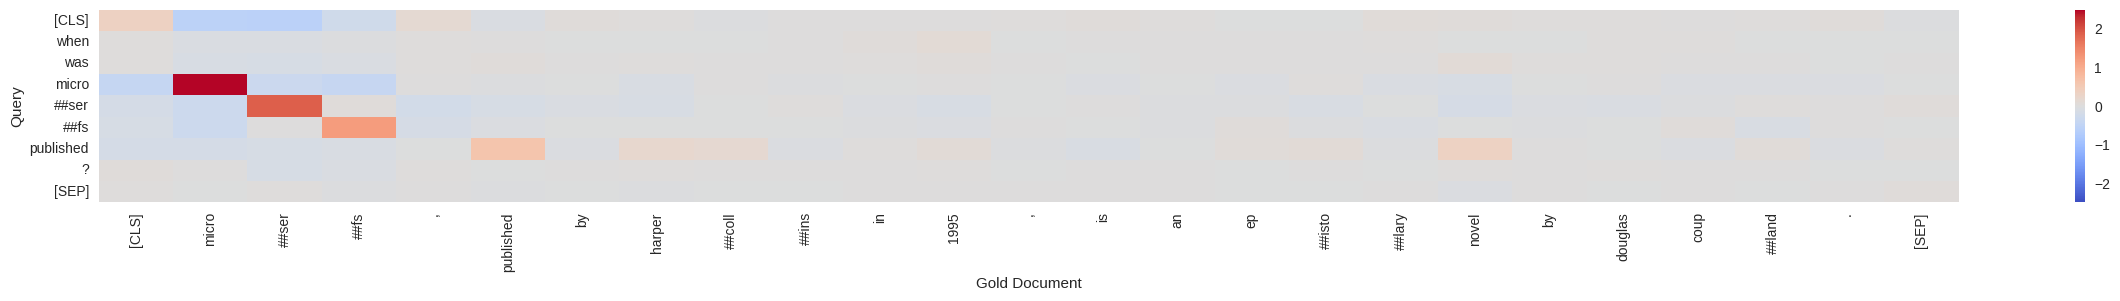

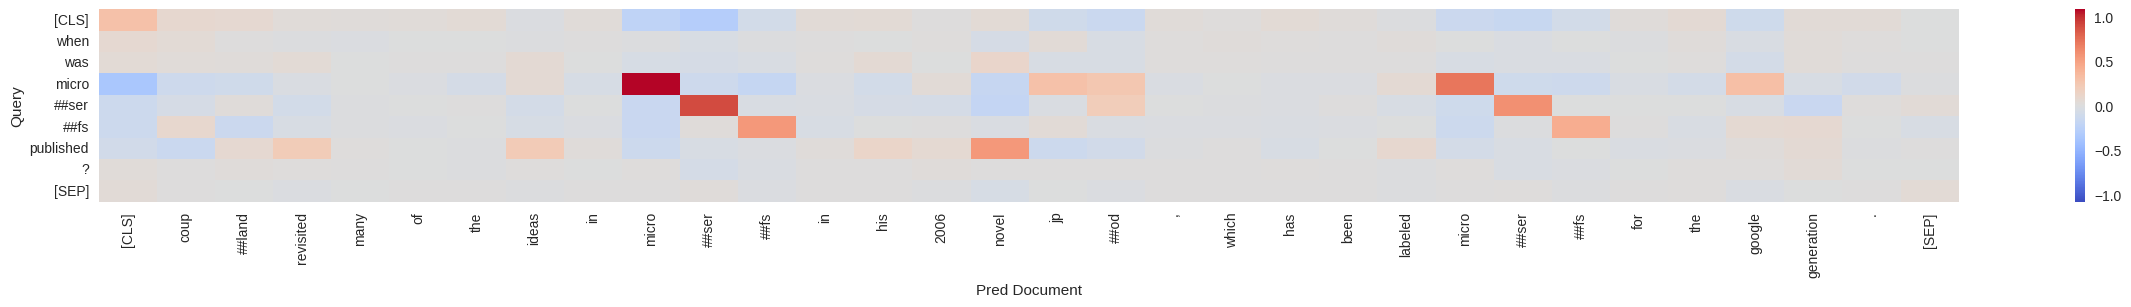

GD
tensor(0.1138) tensor(1.6030) tensor(0.4829) tensor(0.4251) tensor(0.3841) tensor(12) tensor(1)
tensor(12) tensor(1)
tensor([0.5625, 1.6030, 1.3199, 1.1180, 0.2437, 0.4838, 0.1214, 0.5102, 0.2999,
        0.2844])
Q
tensor(0.2713) tensor(1.7115) tensor(0.9757) tensor(0.8883) tensor(0.5591) tensor(8) tensor(3)
tensor(8) tensor(3)
tensor([0.8883, 0.7107, 0.4062, 1.7115, 1.5799, 1.2258, 1.5566, 0.4313, 0.2713])


In [29]:
dq = run_decompx(q[0], model, pooling="avg")
dg = run_decompx(sentences[0], model, pooling="avg")
dd = run_decompx(sentences[1], model, pooling="avg")
dff_dict = {}
for k, v in dq.items():
    dff_dict[f"query_decompx_{k}"] = [v]
for k, v in dg.items():
    dff_dict[f"gold_doc_decompx_{k}"] = [v]
for k, v in dd.items():
    dff_dict[f"pred_doc_decompx_{k}"] = [v]
dff_dict["gold_doc_score"] = np.dot(dg["cls_or_mean_pooled"], dq["cls_or_mean_pooled"])
dff_dict["hit_rank"] = 0
dff_dict["pred_doc_score"] = np.dot(dd["cls_or_mean_pooled"], dq["cls_or_mean_pooled"])
dff = pd.DataFrame(dff_dict)
plot_demo(dff, 0)

In [34]:
# DRAGON
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('facebook/dragon-plus-query-encoder')
query_encoder = AutoModel.from_pretrained('facebook/dragon-plus-query-encoder')
context_encoder = AutoModel.from_pretrained('facebook/dragon-plus-context-encoder')


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [36]:
# We use msmarco query and passages as an example
query =  "Where was Marie Curie born?"
contexts = [
    "Maria Sklodowska, later known as Marie Curie, was born on November 7, 1867.",
    "Born in Paris on 15 May 1859, Pierre Curie was the son of Eugène Curie, a doctor of French Catholic origin from Alsace."
]
# Apply tokenizer
query_input = tokenizer(query, return_tensors='pt')
ctx_input = tokenizer(contexts, padding=True, truncation=True, return_tensors='pt')
# Compute embeddings: take the last-layer hidden state of the [CLS] token
query_emb = query_encoder(**query_input).last_hidden_state[:, 0, :]
ctx_emb = context_encoder(**ctx_input).last_hidden_state[:, 0, :]
# Compute similarity scores using dot product
score1 = query_emb @ ctx_emb[0]  # 396.5625
score2 = query_emb @ ctx_emb[1]  # 393.8340
score1, score2

(tensor([396.5626], grad_fn=<MvBackward0>),
 tensor([393.8340], grad_fn=<MvBackward0>))

In [76]:
# We use msmarco query and passages as an example
query =  "What follows When was Curie born?"
contexts = [
    "Maria Sklodowska, later known as Marie Curie, was born on November 7, 1867.",
    "Ali lives in Paris"
]
# Apply tokenizer
query_input = tokenizer(query, return_tensors='pt')
ctx_input = tokenizer(contexts, padding=True, truncation=True, return_tensors='pt')
# Compute embeddings: take the last-layer hidden state of the [CLS] token
query_emb = query_encoder(**query_input).last_hidden_state[:, 0, :]
ctx_emb = context_encoder(**ctx_input).last_hidden_state[:, 0, :]
# Compute similarity scores using dot product
score1 = query_emb @ ctx_emb[0]  # 396.5625
score2 = query_emb @ ctx_emb[1]  # 393.8340
s3 = ctx_emb[0] @ ctx_emb[0]
print(s3)
score1, score2

tensor(4223.5117, grad_fn=<DotBackward0>)


(tensor([389.3570], grad_fn=<MvBackward0>),
 tensor([368.0791], grad_fn=<MvBackward0>))